In [5]:
# Step 1.1: Load and Preprocess the Wine Dataset

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load Wine dataset
df_wine_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine_data.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']

# Split into features and labels
X_features, y_labels = df_wine_data.iloc[:, 1:].values, df_wine_data.iloc[:, 0].values

# Train-test split
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X_features, y_labels, test_size=0.3, stratify=y_labels, random_state=0)

# Standardize features
scaler_obj = StandardScaler()
X_train_scaled = scaler_obj.fit_transform(X_train_data)
X_test_scaled = scaler_obj.transform(X_test_data)

In [6]:
# Step 1.2: Implement PCA from Scratch

import numpy as np

# Compute covariance matrix
cov_matrix = np.cov(X_train_scaled.T)

# Perform eigendecomposition
eigen_vals, eigen_vecs = np.linalg.eig(cov_matrix)

# Sort eigenvalues in descending order
eigenvalue_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigenvalue_pairs.sort(key=lambda k: k[0], reverse=True)

# Create projection matrix (top 2 components)
projection_matrix = np.hstack((eigenvalue_pairs[0][1][:, np.newaxis],
                              eigenvalue_pairs[1][1][:, np.newaxis]))

# Transform training data
X_train_pca = X_train_scaled.dot(projection_matrix)

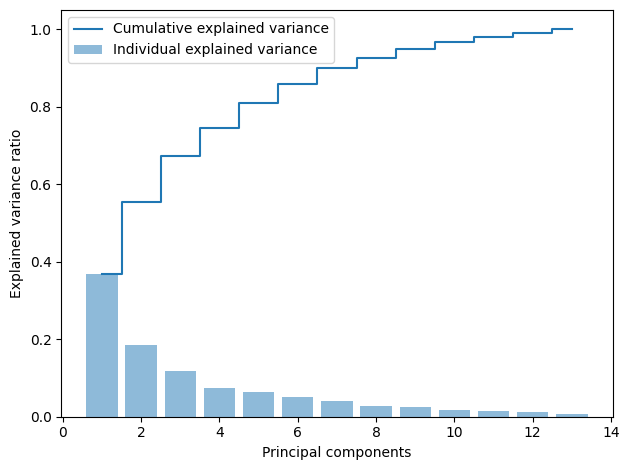

In [7]:
# Step 1.3: Visualize Explained Variance

import matplotlib.pyplot as plt

# Calculate explained variance ratios
total_eigenvalues = sum(eigen_vals)
explained_variance_ratios = [(i / total_eigenvalues) for i in sorted(eigen_vals, reverse=True)]
cumulative_variance = np.cumsum(explained_variance_ratios)

# Plot
plt.bar(range(1, len(explained_variance_ratios) + 1), explained_variance_ratios, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [8]:
# Step 1.4: PCA with scikit-learn

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca_sklearn = pca.fit_transform(X_train_scaled)
X_test_pca_sklearn = pca.transform(X_test_scaled)

c:\Users\comfo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\comfo\AppData\Local\Temp\ipykernel_44044\2000415286.py:27: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x=X[y == cl, 0],
C:\Users\comfo\AppData\Local\Temp\ipykernel_44044\2000415286.py:27: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may chang

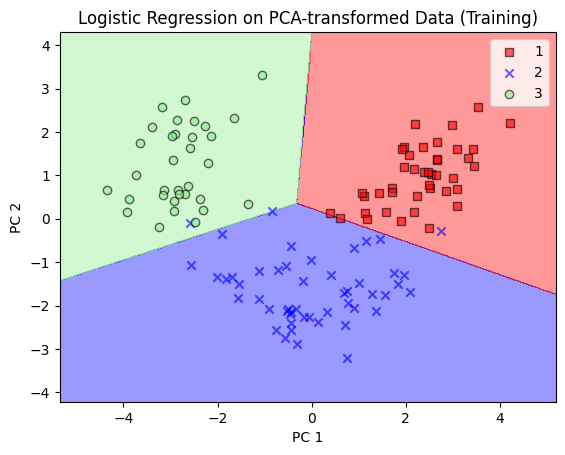

Test Accuracy: 0.926


In [9]:
# Step 1.5: Classification and Visualization

from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
logistic_regression.fit(X_train_pca_sklearn, y_train_data)

# Helper function to plot decision regions (from the book)
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.legend(loc='best')

# Plot decision regions for training set
plot_decision_regions(X_train_pca_sklearn, y_train_data, classifier=logistic_regression)
plt.title('Logistic Regression on PCA-transformed Data (Training)')
plt.show()

# Check accuracy on test set
print('Test Accuracy: %.3f' % logistic_regression.score(X_test_pca_sklearn, y_test_data))

In [15]:
# Part 2: Linear Discriminant Analysis (LDA)

# Step 2.1: Compute Scatter Matrices

# Calculate mean vectors for each class
mean_vectors = [np.mean(X_train_scaled[y_train_data == label], axis=0) for label in np.unique(y_train_data)]

num_features = X_features.shape[1]  # number of features
within_class_scatter = np.zeros((num_features, num_features)) # Within-class scatter matrix
for label, mean_vec in zip(np.unique(y_train_data), mean_vectors):
    class_scatter_matrix = np.cov(X_train_scaled[y_train_data == label].T)
    within_class_scatter += class_scatter_matrix

# Between-class scatter matrix
overall_mean = np.mean(X_train_scaled, axis=0)
between_class_scatter = np.zeros((num_features, num_features))
for i, mean_vec in enumerate(mean_vectors):
    num_samples = X_train_pca[y_train_data == i + 1].shape[0]
    mean_vec = mean_vec.reshape(num_features, 1)
    overall_mean = overall_mean.reshape(num_features, 1)
    between_class_scatter += num_samples * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)

In [16]:
# Step 2.2: Eigendecomposition and Projection

# Solve generalized eigenvalue problem for within_class_scatter^{-1} between_class_scatter
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(within_class_scatter).dot(between_class_scatter))

# Sort eigenvalues in descending order
eigen_pairs = sorted([(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))], key=lambda k: k[0], reverse=True)

# Create projection matrix (top 2 eigenvectors)
lda_projection_matrix = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
                                  eigen_pairs[1][1][:, np.newaxis].real))

# Transform training data
X_train_lda = X_train_scaled.dot(lda_projection_matrix)

In [17]:
# Step 2.3: LDA with scikit-learn

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda_model = LDA(n_components=2)
X_train_lda_sklearn = lda_model.fit_transform(X_train_scaled, y_train_data)
X_test_lda_sklearn = lda_model.transform(X_test_scaled)

c:\Users\comfo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\comfo\AppData\Local\Temp\ipykernel_44044\2000415286.py:27: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x=X[y == cl, 0],
C:\Users\comfo\AppData\Local\Temp\ipykernel_44044\2000415286.py:27: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may chang

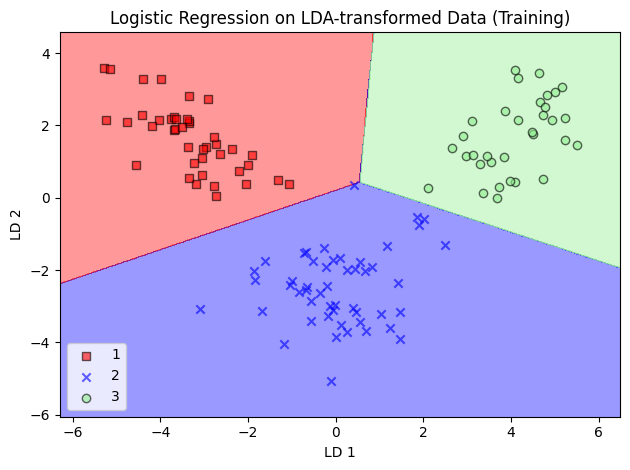

Test Accuracy: 1.000


In [18]:
# Step 2.4: Classification and Visualization

logistic_regression = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
logistic_regression.fit(X_train_lda_sklearn, y_train_data)

plot_decision_regions(X_train_lda_sklearn, y_train_data, classifier=logistic_regression)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.title('Logistic Regression on LDA-transformed Data (Training)')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

print('Test Accuracy: %.3f' % logistic_regression.score(X_test_lda_sklearn, y_test_data))

In [19]:
# Part 3: Kernel Principal Component Analysis (KPCA)

## Step 3.1: Implement RBF Kernel PCA

from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(feature_matrix, gamma_parameter, num_components):
    """
    RBF kernel PCA implementation.
    """
    # Calculate pairwise squared Euclidean distances
    squared_distances = pdist(feature_matrix, 'sqeuclidean')
    
    # Convert pairwise distances into a square matrix
    distance_matrix = squareform(squared_distances)
    
    # Compute the symmetric kernel matrix using NumPy's exp
    kernel_matrix = np.exp(-gamma_parameter * distance_matrix)
    
    # Center the kernel matrix
    num_samples = kernel_matrix.shape[0]
    ones_matrix = np.ones((num_samples, num_samples)) / num_samples
    kernel_matrix = kernel_matrix - ones_matrix.dot(kernel_matrix) - kernel_matrix.dot(ones_matrix) + ones_matrix.dot(kernel_matrix).dot(ones_matrix)
    
    # Obtaining eigenpairs from the centered kernel matrix
    eigenvalues, eigenvectors = eigh(kernel_matrix)
    
    # Collect top k eigenvectors (projected samples)
    projected_components = np.column_stack((eigenvectors[:, -i] for i in range(1, num_components+1)))
    
    return projected_components

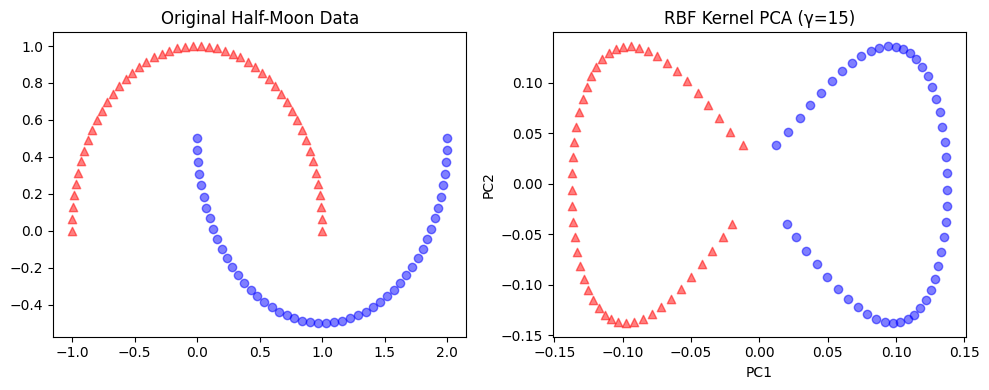

In [20]:
# Step 3.2: Half-Moon Dataset

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh
from sklearn.datasets import make_moons

def rbf_kernel_pca(feature_matrix, gamma_parameter, num_components):
    """
    RBF kernel PCA implementation.
    """
    # Calculate pairwise squared Euclidean distances
    squared_distances = pdist(feature_matrix, 'sqeuclidean')
    
    # Convert pairwise distances into a square matrix
    distance_matrix = squareform(squared_distances)
    
    # Compute the symmetric kernel matrix using NumPy's exp
    kernel_matrix = np.exp(-gamma_parameter * distance_matrix)
    
    # Center the kernel matrix
    num_samples = kernel_matrix.shape[0]
    ones_matrix = np.ones((num_samples, num_samples)) / num_samples
    kernel_matrix = kernel_matrix - ones_matrix.dot(kernel_matrix) - kernel_matrix.dot(ones_matrix) + ones_matrix.dot(kernel_matrix).dot(ones_matrix)
    
    # Obtaining eigenpairs from the centered kernel matrix
    eigenvalues, eigenvectors = eigh(kernel_matrix)
    
    # Collect top k eigenvectors (projected samples)
    projected_components = np.column_stack([eigenvectors[:, -i] for i in range(1, num_components+1)])
    
    return projected_components

# Generate moons dataset
moon_features, moon_labels = make_moons(n_samples=100, random_state=123)

# Apply RBF Kernel PCA
moon_kpca = rbf_kernel_pca(moon_features, gamma_parameter=15, num_components=2)

# Visualize
figure, (axis1, axis2) = plt.subplots(1, 2, figsize=(10, 4))
axis1.scatter(moon_features[moon_labels==0, 0], moon_features[moon_labels==0, 1], color='red', marker='^', alpha=0.5)
axis1.scatter(moon_features[moon_labels==1, 0], moon_features[moon_labels==1, 1], color='blue', marker='o', alpha=0.5)
axis1.set_title('Original Half-Moon Data')

axis2.scatter(moon_kpca[moon_labels==0, 0], moon_kpca[moon_labels==0, 1], color='red', marker='^', alpha=0.5)
axis2.scatter(moon_kpca[moon_labels==1, 0], moon_kpca[moon_labels==1, 1], color='blue', marker='o', alpha=0.5)
axis2.set_xlabel('PC1')
axis2.set_ylabel('PC2')
axis2.set_title('RBF Kernel PCA (γ=15)')
plt.tight_layout()
plt.show()

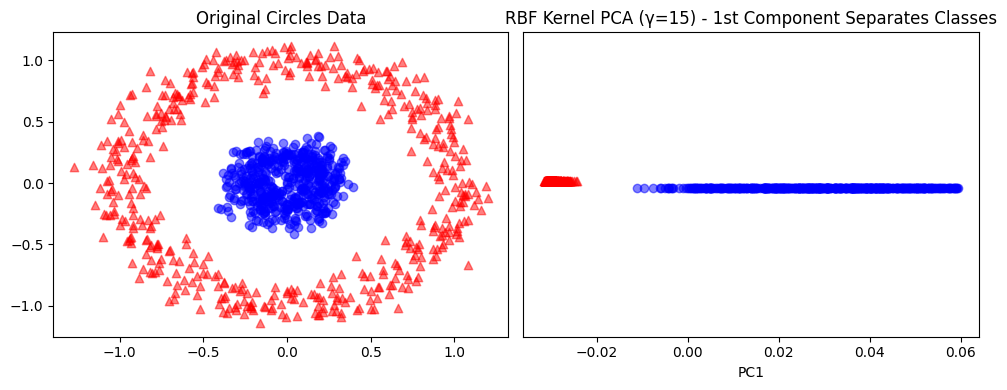

In [21]:
# Step 3.3: Concentric Circles Dataset

from sklearn.datasets import make_circles

# Generate circles dataset
circle_features, circle_labels = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)

# Apply RBF Kernel PCA
circle_kpca = rbf_kernel_pca(circle_features, gamma_parameter=15, num_components=2)

# Visualize
figure, (axis1, axis2) = plt.subplots(1, 2, figsize=(10, 4))
axis1.scatter(circle_features[circle_labels==0, 0], circle_features[circle_labels==0, 1], 
              color='red', marker='^', alpha=0.5)
axis1.scatter(circle_features[circle_labels==1, 0], circle_features[circle_labels==1, 1], 
              color='blue', marker='o', alpha=0.5)
axis1.set_title('Original Circles Data')

# Add slight y-jitter for clearer visualization
axis2.scatter(circle_kpca[circle_labels==0, 0], np.zeros((circle_labels==0).sum()) + 0.02, 
              color='red', marker='^', alpha=0.5)
axis2.scatter(circle_kpca[circle_labels==1, 0], np.zeros((circle_labels==1).sum()) - 0.02, 
              color='blue', marker='o', alpha=0.5)
axis2.set_ylim([-1, 1])
axis2.set_yticks([])
axis2.set_xlabel('PC1')
axis2.set_title('RBF Kernel PCA (γ=15) - 1st Component Separates Classes')

plt.tight_layout()
plt.show()


In [22]:
# Step 3.4: KPCA with scikit-learn

from sklearn.decomposition import KernelPCA

# Apply scikit-learn's KernelPCA on the circles dataset
circle_kpca_sk = KernelPCA(n_components=2, kernel='rbf', gamma=15)
circle_features_kpca = circle_kpca_sk.fit_transform(circle_features)
